# Mitochondria Displacement Plots
Script that goes through analyzed data and makes plots of mitochondria displacements
### File location parameters

In [1]:
analyzed_data_dir = '/Users/adam/Documents/SenseOfTouchResearch/SSN_AnalyzedData/'
fig_save_dir = analyzed_data_dir + 'PreliminaryPlots/'

### Choose worm strain and neuron

In [2]:
worm_strains = ['NM3573', 'GN885']
current_neuron = 'ALM'

allele_dict = {'NM3573': 'wild-type',
               'GN885': 'him-4(e1267)',
               'GN886': 'mec-1(e1066)',
               'GN887': 'mec-1(e1738)'}

### Experimental parameters

In [3]:
pixel_to_micron = 0.275

### Import packages

In [4]:
import yaml
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy import stats
import warnings
import glob
import numpy as np
import typing
import pathlib
import seaborn as sns
import pathlib

for current_worm_strain in worm_strains:
    current_strain_TRN = current_worm_strain + '_' + current_neuron
    fig_path = pathlib.Path(fig_save_dir + current_strain_TRN)
    if fig_path.exists() is False:
        fig_path.mkdir()

### Functions for creating dataframes

In [5]:
def get_experiment_df(analyzed_data_dir):
    analyzed_trials = glob.iglob(analyzed_data_dir + '*')
    all_metadata = []
    for trial in analyzed_trials:
        try:
            with open(trial + '/metadata.yaml') as metadata_file:
                all_metadata.append(yaml.safe_load(metadata_file))
        except FileNotFoundError:
            pass
        except NotADirectoryError:
            pass

    metadata_df = pd.DataFrame(all_metadata)
    
    return metadata_df


### Functions for manipulating dataframes

In [6]:
def calc_x_distance(row):
    return distance.euclidean([row['x']], [row['x_rest']])

def calc_xz_distance(row):
    return distance.euclidean([row['x'], row['z']], [row['x_rest'], row['z_rest']])

def calc_xyz_distance(row):
    return distance.euclidean([row['x'], row['y'], row['z']], [row['x_rest'],  row['y_rest'], row['z_rest']])

# def calc_x_stretch(row):
#     print('calc_x_stretch function not implemented')
# #     return distance.euclidean([row['x']], [row['x_rest']])

# def calc_xz_stretch(row):
#     print('calc_xz_stretch function not implemented')
# #     return distance.euclidean([row['x'], row['z']], [row['x_rest'], row['z_rest']])

# def calc_xyz_stretch(row):
#     print('calc_xyz_stretch function not implemented')
# #     return distance.euclidean([row['x'], row['y'], row['z']], [row['x_rest'],  row['y_rest'], row['z_rest']])

# def calc_x_strain(row):
#     print('calc_x_strain function not implemented')
# #     return distance.euclidean([row['x']], [row['x_rest']])

# def calc_xz_strain(row):
#     print('calc_xz_strain function not implemented')
# #     return distance.euclidean([row['x'], row['z']], [row['x_rest'], row['z_rest']])

# def calc_xyz_strain(row):
#     print('calc_xyz_strain function not implemented')
# #     return distance.euclidean([row['x'], row['y'], row['z']], [row['x_rest'],  row['y_rest'], row['z_rest']])

### Function for plotting

In [7]:
def plot_disp_centered_on_actuator(linked_mitos_df: pd.DataFrame,
                                   metadata_df: pd.DataFrame,
                                   disp_component: str,
                                   ax: mpl.axes.Axes=None,
                                   normalization: bool=False):
    actuator_center_coords = metadata_df['actuator_center'].apply(pd.Series).stack()
    if metadata_df['head_orientation'].str.contains('Headfirst').all():
        worm_head_direction = -1
    elif metadata_df['head_orientation'].str.contains('Tailfirst').all():
        worm_head_direction = 1
    else:
        raise ValueError
    linked_mitos_df['corrected_y'] = worm_head_direction * pixel_to_micron * (
        linked_mitos_df['y'] - actuator_center_coords[1])
    linked_mitos_df['x_disp'] = linked_mitos_df.apply(calc_x_distance, axis=1) * pixel_to_micron 
    linked_mitos_df['xz_disp'] = linked_mitos_df.apply(calc_xz_distance, axis=1) * pixel_to_micron 
    linked_mitos_df['xyz_disp'] = linked_mitos_df.apply(calc_xyz_distance, axis=1) * pixel_to_micron 
    
    plot_axes = disp_component + '_disp'
    
    if normalization is True:
        linked_mitos_df[plot_axes + '_normalized']=(linked_mitos_df[plot_axes]/linked_mitos_df[plot_axes].max())
        plot_axes += '_normalized'
    
    if ax is None:
        fig, ax = plt.subplots()
        plot_title = metadata_df.loc[:,'Experiment_id'].values[0]
    else:
        plot_title = current_neuron + ' of ' + allele_dict[metadata_df['worm_strain'].values[0]]

    linked_mitos_df.loc[linked_mitos_df['pressure'] == 0].groupby(['frame']).plot(
            x='corrected_y', y=plot_axes,
            color='#e66101', kind='scatter', ax=ax)
    linked_mitos_df.loc[linked_mitos_df['pressure'] == 300].groupby(['frame']).plot(
                x='corrected_y', y=plot_axes, title=plot_title,
                color='#5e3c99', kind='scatter', ax=ax)
    ax.set_xlabel('Longitudinal distance (um)')
    ax.set_ylabel('Displacement normal to worm length (um)')

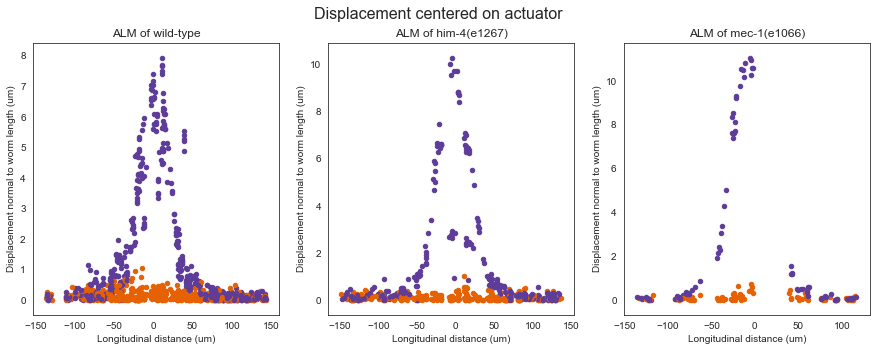

In [23]:
# get all the metadata
all_metadata = get_experiment_df(analyzed_data_dir)
# select only the trials we want
trials_with_strain_and_actuator = all_metadata.loc[(all_metadata['analysis_status'] == 'Strain calculated') &
                                                   (all_metadata['actuator_center'].notnull()) &
                                                   (all_metadata['neuron'] == current_neuron)]
n_trials_dict = trials_with_strain_and_actuator['worm_strain'].value_counts().to_dict()

# make plots for those trials
fig, axes = plt.subplots(ncols=len(worm_strains), figsize=(5 * len(worm_strains),5))
fig.suptitle('Displacement centered on actuator', fontsize=16)
ax_index = 0
for genotype in worm_strains:
    for index, row in trials_with_strain_and_actuator.loc[
            trials_with_strain_and_actuator['worm_strain'] == genotype].iterrows():
        experiment_id = row['Experiment_id']
        metadata = trials_with_strain_and_actuator.loc[all_metadata['Experiment_id'] == experiment_id]

        strain_file = analyzed_data_dir + experiment_id + '/strain.yaml'
        with open(strain_file, 'r') as yamlfile:
            strain_df = yaml.safe_load(yamlfile)
        strain_df = pd.DataFrame(strain_df)

        linked_mitos_file = analyzed_data_dir + experiment_id + '/mito_locations.yaml'
        with open(linked_mitos_file, 'r') as yamlfile:
            linked_mitos_df = yaml.safe_load(yamlfile)
        linked_mitos_df = pd.DataFrame.from_dict(linked_mitos_df)

        plot_disp_centered_on_actuator(linked_mitos_df, metadata, 'x', axes[ax_index])
        # shade by trial
    #     plot_disp_centered_on_actuator(linked_mitos_df, metadata, 'x', ax2, True)
    #     plot_disp_centered_on_actuator(linked_mitos_df, metadata, 'x')
    #     plot_disp_centered_on_actuator(linked_mitos_df, metadata, 'xz', ax)
    #     plot_disp_centered_on_actuator(linked_mitos_df, metadata, 'xyz')
#     fig.savefig(fig_save_dir + genotype + '_' + current_neuron + '/aggregatedDisplacement.png')
    ax_index += 1


fig.savefig(fig_save_dir + current_neuron + '/aggregatedDisplacement.png')


## Strain plots
Strain is really what we'd like to know, since it quantifies the deformation of the neuron. It can be calculated according to: 

$\epsilon = \frac{L - L_0}{L_0}$

Where $L$ is the current length of the object and $L_0$ is the undeformed length. A strain measurement is thus particularly sensitive to the choice of an undeformed configuration. For the sparse, noisy data we have, a few choices are:

1. Use the average of all lengths between the same pair of mitochondria in the condition where pressure=0
2. Use the length between the same pair of mitochondria in the stack immediately preceding the actuation
3. Use the averate lengths between the same pair of mitochondria in the stack immediately before and after the actuation

### Strain calcs with different reference distances

In [10]:
'''Option 1 above already in the strain_df since I do it that way in spyder'''

def calc_strain_rest_before(row):
    '''Option 2 above'''
    if row['pressure'] != 0:
        before_rest = strain_df.loc[
            (strain_df['frame'] == row['frame'] - 1) &
            (strain_df['pair_id'] == row['pair_id'])]['total_dist'].values
        before_strain = (row['total_dist'] - before_rest) / before_rest
    else:
        before_strain = 0
    return float(before_strain)

def calc_strain_rest_before_after(row):
    '''Option 3 above'''
    if row['frame'] < strain_df['frame'].max():
        if row['pressure'] != 0:
            before_rest = strain_df.loc[
                (strain_df['frame'] == row['frame'] - 1) &
                (strain_df['pair_id'] == row['pair_id'])]['total_dist']
            after_rest = strain_df.loc[
                (strain_df['frame'] == row['frame'] + 1) &
                (strain_df['pair_id'] == row['pair_id'])]['total_dist']
            rest = np.mean([before_rest.values, after_rest.values])
            before_after_strain = (row['total_dist'] - rest) / rest
        else:
            before_after_strain = 0
    else:
        before_after_strain = None
        
#     print(type(before_after_strain), before_after_strain)
    return before_after_strain

def calc_stretch_rest_before_after(row):
    '''Stretch calculation with option 3 above'''
    if row['frame'] < strain_df['frame'].max():
        if row['pressure'] != 0:
            before_rest = strain_df.loc[
                (strain_df['frame'] == row['frame'] - 1) &
                (strain_df['pair_id'] == row['pair_id'])]['total_dist']
            after_rest = strain_df.loc[
                (strain_df['frame'] == row['frame'] + 1) &
                (strain_df['pair_id'] == row['pair_id'])]['total_dist']
            rest = np.mean([before_rest.values, after_rest.values])
            before_after_stretch = (row['total_dist'] - rest) * pixel_to_micron
        else:
            before_after_stretch = 0
    else:
        before_after_stretch = None
        
#     print(type(before_after_strain), before_after_strain)
    return before_after_stretch

### Functions for plotting strain

In [16]:
def plot_strain_centered_on_actuator(strain_df: pd.DataFrame,
                                     linked_mitos_df: pd.DataFrame,
                                     metadata_df: pd.DataFrame,
                                     strain_calc_opt: str='strain',
                                     ax: mpl.axes.Axes=None):
    actuator_center_coords = metadata_df['actuator_center'].apply(pd.Series).stack()
    if metadata['head_orientation'].str.contains('Headfirst').all():
        worm_head_direction = -1
    elif metadata['head_orientation'].str.contains('Tailfirst').all():
        worm_head_direction = 1
    else:
        raise ValueError
        
    strain_df['before_strain'] = strain_df.apply(calc_strain_rest_before, axis=1)
    strain_df['before_after_strain'] = strain_df.apply(calc_strain_rest_before_after, axis=1) 
    linked_mitos_df['corrected_y'] = worm_head_direction * (linked_mitos_df['y'] - actuator_center_coords[1])
    corrected_y_vals = []

    for index, row in strain_df.iterrows():
        corrected_y_vals.append(linked_mitos_df.loc[
                (linked_mitos_df['frame'] == row['frame']) &
                (linked_mitos_df['particle'] == row['particle_1'])]['corrected_y'].values[0])
    strain_df['corrected_y'] = corrected_y_vals
    strain_df['corrected_y'] *= pixel_to_micron # pixel size correction

    if ax is None:
        fig, ax = plt.subplots()
        plot_title = metadata_df.loc[:,'Experiment_id'].values[0]
    else:
        plot_title = current_neuron + ' of ' + allele_dict[current_worm_strain]

    plot_spec = {'x': 'corrected_y',
                 'y': strain_calc_opt,
                 'alpha': 0.25,
                 'ax': ax,
                 'drawstyle': 'steps',
                 'title': plot_title}#,
#                  'figsize': (10, 5)}
    strain_df.loc[strain_df['pressure'] == 0].groupby(['frame']).plot(
            **plot_spec, color='#e66101')
    strain_df.loc[strain_df['pressure'] == 300].groupby(['frame']).plot(
            **plot_spec, color='#5e3c99')
    ax.get_legend().remove()
    ax.set_ylabel(strain_calc_opt)
    
#     max_strain = strain_df.loc[strain_df[strain_calc_opt].idxmax()]
#     max_strain_location = linked_mitos_df.loc[
#         (linked_mitos_df['particle'] == max_strain['particle_1']) &
#         (linked_mitos_df['frame'] == max_strain['frame'])]
#     max_strain_location_2 = linked_mitos_df.loc[
#         (linked_mitos_df['particle'] == max_strain['particle_2']) &
#         (linked_mitos_df['frame'] == max_strain['frame'])]
#     display(max_strain[[strain_calc_opt]])
#     display(max_strain_location)
#     display(max_strain_location_2)
#     ax.text(x=max_strain_location['corrected_y'].values[0],
#             y=max_strain[strain_calc_opt],
#             s=metadata['Experiment_id'].values[0])
    
def sample_strain(linked_mitos_df: pd.DataFrame,
                  metadata_df: pd.DataFrame,
                  y_coords: np.ndarray,
                  frame_num: int,
                  strain_calc_opt: str='strain') -> pd.DataFrame:
    '''Samples piecwise strain for later averaging'''
    actuator_center_coords = metadata_df['actuator_center'].apply(pd.Series).stack()
    if metadata['head_orientation'].str.contains('Headfirst').all():
        worm_head_direction = -1
    elif metadata['head_orientation'].str.contains('Tailfirst').all():
        worm_head_direction = 1
    else:
        raise ValueError
    strain_df['before_strain'] = strain_df.apply(calc_strain_rest_before, axis=1)
    strain_df['before_after_strain'] = strain_df.apply(calc_strain_rest_before_after, axis=1) 
    strain_df['before_after_stretch'] = strain_df.apply(calc_stretch_rest_before_after, axis=1)

    linked_mitos_df['corrected_y'] = worm_head_direction * (linked_mitos_df['y'] - actuator_center_coords[1])
    strain_df_this_frame = strain_df.loc[strain_df['frame'] == frame_num].copy()
    
    sampled_strain_df = pd.DataFrame(columns=['y_coord', 'experiment_id'] + strain_calc_opt)
    sampled_strain_df['y_coord'] = y_coords
    sampled_strain_df['y_dist'] = sampled_strain_df.apply(lambda row: row.y_coord * 0.275, axis=1)
    sampled_strain_df['experiment_id'] = experiment_id
    sampled_strain_df['worm_strain'] = metadata['worm_strain'].values[0]

    for pair in strain_df_this_frame['pair_id']:
        # get particles in this pair
        particle1 = strain_df_this_frame.loc[strain_df_this_frame['pair_id'] == pair]['particle_1'].values[0]
        particle2 = strain_df_this_frame.loc[strain_df_this_frame['pair_id'] == pair]['particle_2'].values[0]
        
        # get y values of these particles in this frame
        y_part1 = linked_mitos_df.loc[(linked_mitos_df['frame'] == frame_num) &
                                      (linked_mitos_df['particle'] == particle1)]['corrected_y'].values[0]
        y_part2 = linked_mitos_df.loc[(linked_mitos_df['frame'] == frame_num) &
                                      (linked_mitos_df['particle'] == particle2)]['corrected_y'].values[0]
        bigger_y = max(y_part1, y_part2)
        smaller_y = min(y_part1, y_part2)
        # get strain between these two particles in this frame
        strain_this_pair = strain_df_this_frame.loc[
                strain_df_this_frame['pair_id'] == pair][strain_calc_opt].values[0]
        
        # save this strain for all y_coords on this interval
        sampled_strain_df.loc[
            (sampled_strain_df['y_coord'] > smaller_y) & 
            (sampled_strain_df['y_coord'] < bigger_y), strain_calc_opt] = strain_this_pair

#     sampled_strain = sampled_strain_df[strain_calc_opt]
    float_columns = {key: float for key in strain_calc_opt}
    float_columns['y_coord'] = float
    sampled_strain_df = sampled_strain_df.astype(float_columns)

    return sampled_strain_df

# sampled_strain_df= sample_strain(linked_mitos_df, metadata, np.arange(-1000,1000,1), 1, 'before_after_strain')

### Make the plots!

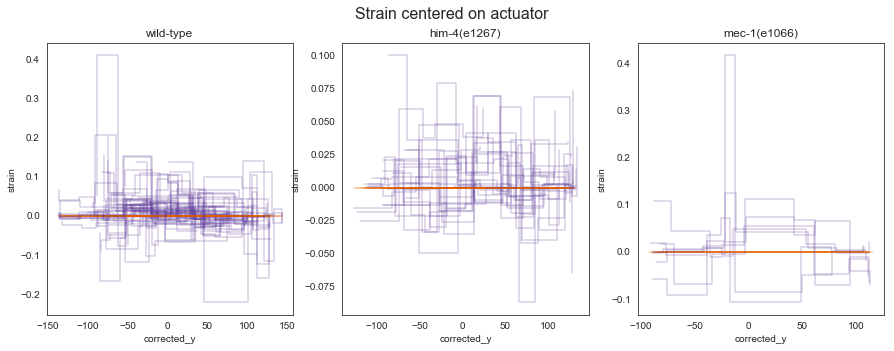

In [17]:
# make strain plots for previously selected trials
y_coords_to_sampled = np.arange(-1000,1000,1)
sampled_strain_df = pd.DataFrame()
actuator_strain_df = pd.DataFrame()
fig, axes = plt.subplots(figsize=(5 * len(worm_strains) ,5), ncols=len(worm_strains))
fig.suptitle('Strain centered on actuator', fontsize=16)
ax_index = 0
n_trials = trials_with_strain_and_actuator.shape[0]
for genotype in worm_strains:
    for index, row in trials_with_strain_and_actuator.loc[
            trials_with_strain_and_actuator['worm_strain'] == genotype].iterrows():
        experiment_id = row['Experiment_id']
    #     print('Working on', experiment_id)
        metadata = trials_with_strain_and_actuator.loc[all_metadata['Experiment_id'] == experiment_id]

        strain_file = analyzed_data_dir + experiment_id + '/strain.yaml'
        with open(strain_file, 'r') as yamlfile: 
            strain_df = yaml.safe_load(yamlfile)
        strain_df = pd.DataFrame(strain_df)

        linked_mitos_file = analyzed_data_dir + experiment_id + '/mito_locations.yaml'
        with open(linked_mitos_file, 'r') as yamlfile:
            linked_mitos_df = yaml.safe_load(yamlfile)
        linked_mitos_df = pd.DataFrame.from_dict(linked_mitos_df)

        plot_strain_centered_on_actuator(strain_df, linked_mitos_df,
                                         metadata, 'before_after_strain', axes[ax_index])
        

        for frame in linked_mitos_df.loc[linked_mitos_df['pressure']==300]['frame'].unique():
            sampled_strain_df = pd.concat([sampled_strain_df, sample_strain(linked_mitos_df=linked_mitos_df,
                                           metadata_df=metadata,
                                           y_coords=y_coords_to_sampled,
                                           frame_num=frame,
                                           strain_calc_opt=['before_after_strain','before_after_stretch'])],
                                          ignore_index=True, sort=False)
        actuator_strain_df = pd.concat([actuator_strain_df,
                                        sampled_strain_df.loc[sampled_strain_df['y_coord'] == 0]],
                                           ignore_index=True, sort=False)
    axes[ax_index].set_ylabel('strain')
    axes[ax_index].set_title(allele_dict[genotype])
    ax_index += 1


fig.savefig(fig_save_dir + current_neuron + '/aggregatedStrain_noSampling.png')

In [24]:
strain_df.head()

,frame,pair_id,particle_1,particle_2,pressure,rest_dist,strain,total_dist,x_dist,x_rest_dist,x_strain,y_dist,y_rest_dist,y_strain,z_dist,z_rest_dist,z_strain
0,0,0,10,12,0,70.536643,-0.014821,69.491216,1.750385,1.472899,0.188395,69.465391,70.498353,-0.014652,0.724370,1.305114,-0.444976
1,0,1,12,14,0,121.953839,-0.000877,121.846862,0.585743,1.050786,-0.442568,121.823919,121.938621,-0.000941,2.290753,1.318622,0.737233
2,0,2,14,9,0,70.409931,0.091453,76.849119,3.674667,1.971425,0.863965,76.394682,70.274233,0.087094,7.492430,2.718542,1.756047
3,0,3,9,17,0,158.573648,-0.017643,155.775957,7.486011,4.537838,0.649687,155.592617,158.303262,-0.017123,1.022813,5.411746,-0.811001
4,0,4,17,19,0,69.258039,0.078503,74.695026,8.105411,5.266608,0.539019,73.715363,68.662240,0.073594,8.927181,5.972937,0.494605


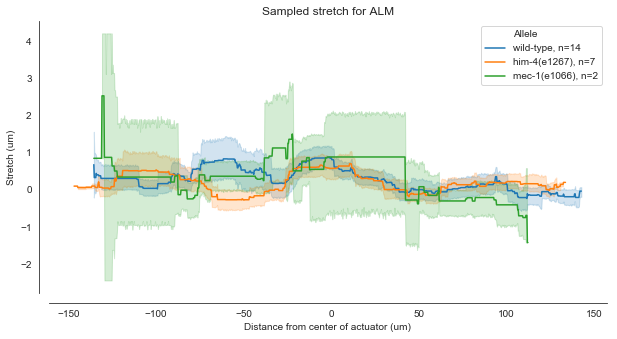

In [13]:
sns.set_style('white')

fig3, ax3 = plt.subplots(figsize=(10,5))
sns.lineplot(x='y_dist', y='before_after_stretch', data=sampled_strain_df, hue='worm_strain')
# n_trials_text = mpl.offsetbox.AnchoredText('n =' + str(n_trials), loc="upper right", frameon=False)
# ax3.add_artist(n_trials_text)
sns.despine(ax=ax3, offset=10)
h, labels = ax3.get_legend_handles_labels()
labels = [(allele_dict[label] + ', n=' + str(n_trials_dict[label])) if label in allele_dict else 'Allele' for label in labels]
ax3.legend(h, labels)
ax3.set(xlabel='Distance from center of actuator (um)', ylabel='Stretch (um)',
        title=('Sampled stretch for ' + current_neuron))# + ' of ' + allele_dict[current_worm_strain]))

fig3.savefig(fig_save_dir + current_neuron + '/sampled_stretch.png')

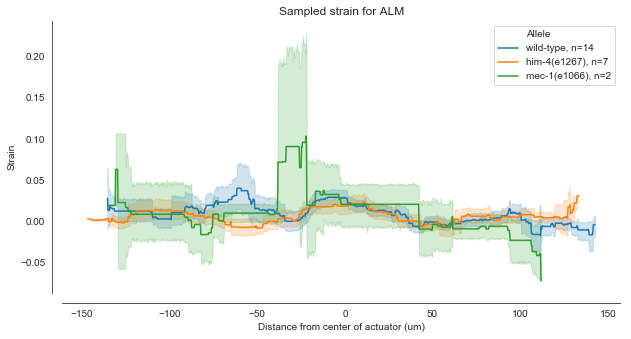

In [14]:
fig4, ax4 = plt.subplots(figsize=(10,5))
sns.lineplot(x='y_dist', y='before_after_strain', data=sampled_strain_df, 
             legend='brief', hue='worm_strain')
# n_trials_text = mpl.offsetbox.AnchoredText('n =' + str(n_trials), loc="upper right", frameon=False)
# ax4.add_artist(n_trials_text)
sns.despine(offset=10)
h, labels = ax4.get_legend_handles_labels()
labels = [(allele_dict[label] + ', n=' + str(n_trials_dict[label])) if label in allele_dict else 'Allele' for label in labels]
ax4.legend(h, labels)
ax4.set(xlabel='Distance from center of actuator (um)', ylabel='Strain',
        title=('Sampled strain for ' + current_neuron))# + ' of ' + allele_dict[current_worm_strain]))
fig4.savefig(fig_save_dir + current_neuron + '/sampled_strain.png')

KeyboardInterrupt: 

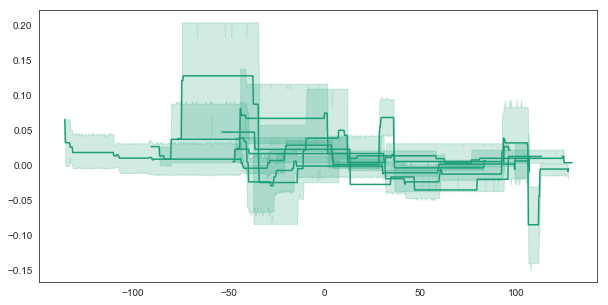

In [15]:
# dash_styles = ["", "", "", "", "", "", "", "", 
#                (4, 1.5), (4, 1.5), (4, 1.5), (4, 1.5), (4, 1.5), (4, 1.5), (4, 1.5), (4, 1.5),
#                (1.5, 1.5), (1.5, 1.5), (1.5, 1.5), (1.5, 1.5), (1.5, 1.5), (1.5, 1.5), (1.5, 1.5), (1.5, 1.5), ]
# fig5, ax5 = plt.subplots(figsize=(10,5))
# sns.lineplot(x='y_dist', y='before_after_strain', data=sampled_strain_df, hue='worm_strain',
#              style='experiment_id', legend='brief', palette='Dark2', dashes=dash_styles)

# # n_trials_text = mpl.offsetbox.AnchoredText('n =' + str(n_trials), loc="upper right", frameon=False)
# # ax5.add_artist(n_trials_text)
# sns.despine(offset=10)
# h, labels = ax5.get_legend_handles_labels()
# labels = [(allele_dict[label] + ', n=' + str(n_trials_dict[label])) if label in allele_dict else 'Allele' for label in labels]
# ax5.legend(h, labels)
# plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)

# ax5.set(xlabel='Distance from center of actuator (um)', ylabel='Strain',
#         title=('Strain for ' + current_neuron))# + ' of ' + allele_dict[current_worm_strain]))
# fig5.savefig(fig_save_dir + current_neuron + '/sampled_strain_by_exp.png')

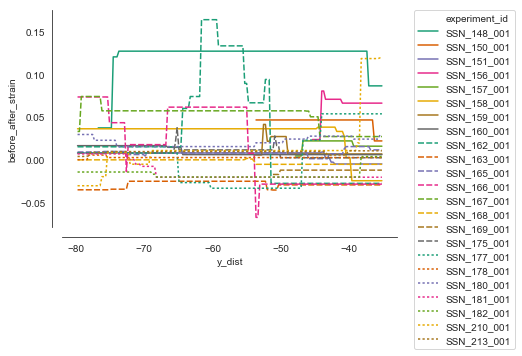

In [20]:
sampled_strain_anterior_section = sampled_strain_df.loc[(sampled_strain_df['y_dist'] < -35) &
                                                        (sampled_strain_df['y_dist'] > -80)]
fig6, ax6 = plt.subplots()
sns.lineplot(x='y_dist', y='before_after_strain', data=sampled_strain_anterior_section,
             hue='experiment_id', style='experiment_id', legend='brief', palette='Dark2', dashes=dash_styles,
             ci=None)
# n_trials_text = mpl.offsetbox.AnchoredText('n =' + str(n_trials), loc="upper right", frameon=False)
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)

# ax6.add_artist(n_trials_text)
sns.despine(offset=10)
ax6.set_label('strain')

There's something weird with the anterior side of the plot. I need to check out the raw data and see if the particle localization is working properly. Start with SSN_148, SSN_162, and SSN_166.

### Strain at middle of the actuator

In [ ]:
# sampled_strain_df.loc[sampled_strain_df['y_coord'] == 0]

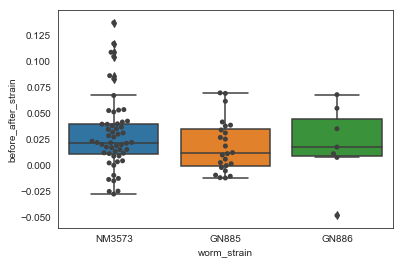

In [19]:
fig7, ax7 = plt.subplots()
sns.boxplot(x='worm_strain', y='before_after_strain',
               data=sampled_strain_df.loc[sampled_strain_df['y_coord'] == 0])
sns.swarmplot(x='worm_strain', y='before_after_strain', color=".25",
               data=sampled_strain_df.loc[sampled_strain_df['y_coord'] == 0])

In [21]:
sampled_strain_df.head()

,y_coord,experiment_id,before_after_strain,before_after_stretch,y_dist,worm_strain
0,-1000.0,SSN_148_001,NaN,NaN,-275.000,NM3573
1,-999.0,SSN_148_001,NaN,NaN,-274.725,NM3573
2,-998.0,SSN_148_001,NaN,NaN,-274.450,NM3573
3,-997.0,SSN_148_001,NaN,NaN,-274.175,NM3573
4,-996.0,SSN_148_001,NaN,NaN,-273.900,NM3573


## Contour Length of TRN
When the actuator is active, the overall length of the neuron increases while stretching. Krieg et al. (2017) used this measurement to explore the effect of TRN position on mechanical strain due to normal locomotion of a worm.

In [ ]:
def plot_total_neuron_length_change(metadata_df: pd.DataFrame,
                                    ax: mpl.axes.Axes=None):
    mean_length_no_pressure = []
    mean_length_300kPa = []
    for index, row in metadata_df.iterrows():
        experiment_id = row['Experiment_id']
        metadata = trials_with_strain_and_actuator.loc[metadata_df['Experiment_id'] == experiment_id]

        strain_file = pathlib.Path(analyzed_data_dir, experiment_id, 'strain.yaml')
        with open(strain_file, 'r') as yamlfile:
            strain_df = yaml.safe_load(yamlfile)
        strain_df = pd.DataFrame(strain_df)
        
        total_dist = strain_df.groupby(['frame'])['total_dist'].sum()
        pressure = strain_df.groupby(['frame'])['pressure'].max()
        avg_dist_by_pressure = strain_df.groupby(['pressure']).mean()
        TRN_length_and_pressure = pd.DataFrame([total_dist, pressure]).transpose()
#         print(avg_dist_by_pressure)
#         print(total_dist)
        mean_length_no_pressure.append(
            TRN_length_and_pressure.loc[TRN_length_and_pressure[
                'pressure'] == 0]['total_dist'].mean())
        mean_length_300kPa.append(
            TRN_length_and_pressure.loc[TRN_length_and_pressure[
                'pressure'] == 300]['total_dist'].mean())
        
#         if ax is None:
#             fig, ax = plt.subplots()
#             plot_title = metadata.loc[:,'Experiment_id'].values[0]
#         else:
#             plot_title = None

        
#         TRN_length_and_pressure.boxplot(column=['total_dist'], by='pressure', ax=ax)
#         display(TRN_length_and_pressure)
        
        
#         TRN_length_and_pressure.loc[TRN_length_and_pressure['pressure'] == 300].boxplot(column=['total_dist'])
#         linked_mitos_df.loc[linked_mitos_df['pressure'] == 0].groupby(['frame']).plot(
#                 x='corrected_y', y=plot_axes,
#                 color='#e66101', kind='scatter', ax=ax)
#         linked_mitos_df.loc[linked_mitos_df['pressure'] == 300].groupby(['frame']).plot(
#                     x='corrected_y', y=plot_axes, title=plot_title,
#                     color='#5e3c99', kind='scatter', ax=ax)
    mean_length_no_pressure = np.array(mean_length_no_pressure)
    mean_length_300kPa = np.array(mean_length_300kPa)
    fig, ax = plt.subplots()
    ax.boxplot([mean_length_300kPa - mean_length_no_pressure])#, labels=['300 kPa', '0 kPa'])
    ax.set_ylabel('Measured TRN length change in pixels')

plot_total_neuron_length_change(trials_with_strain_and_actuator)

In [ ]:
metadata

## Displacement profile fitting
Most mechanical models use continuous, differentiable functions, but the empirical data we have is discontinuous. One way to solve this problem is to fit the data with a continuous curve. Our data is also pretty sparse, because there are not many mitochondria in a given TRN. 

To get around this problem, I am first fitting different types of curves to the pooled, normalized displacement measurements, and choosing the best function to fit based on statistical goodness of fit tests. Next, I use the function that provides the best fit to fit individual trials and get a continuous, differentiable representation of the displacement of mitochondria in the trial.

Open questions: 
- What is the best way to normalize? Should I use the largest measured value, even though it might not be the largest displacement of the neuron if the mitochondrion was not in the center of the actuator? Should I instead fit the individual trials and use the max value of the fit?

In [ ]:
def fit_pooled_displacements(metadata_df: pd.DataFrame):
    pass
    # for each trial
        # load linked_mitos
        # subtract off rest position for all three dimensions
        # normalize to largest displacement
        # add to pooled data
    
    # for each function to fit
        # calculate least squares fit
        # calculate goodness of fit
        # plot fit with pooled data
        
    # return name of function that fits best

## Testing functions to make sure analysis works properly

In [ ]:
# import unittest

# class TestDataframeBuilders(unittest.TestCase):
        
#     def setUp(self):
#         self.analyzed_data_dir = '/Users/adam/Documents/SenseOfTouchResearch/SSN_ImageAnalysis/AnalyzedData/'
#         self.all_metadata = get_experiment_df(self.analyzed_data_dir)
#         self.test_cases = 'SSN_120_001'

#     def test_make_trial_df(self):
#         for exp_id in self.test_cases:
#             this_trial_mitos = make_trial_df(exp_id, self.all_metadata)
            




# unittest.main(argv=[''], verbosity=2, exit=False)